## Pixel Transformer (PiT)

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

### Data Loading and Processing

In this section, we load the CIFAR-10 dataset from the official website: [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  
The dataset consists of five training files (each named `data_batch_i` where i is the file number) and one test file.



#### Processing Workflow
1. **Loading and Processing:** Each data batch was processed individually due to insufficient RAM when running this notebook in Google Colab.
2. **Image Conversion:** The 1D image data was converted into pixel-by-pixel image arrays.
3. **Saving Intermediate Results:** Each processed batch was saved as a separate file.
4. **Merging Batches:** The processed training batches were merged into a single file and saved.
5. **Test File:** The test file was processed and saved separately.

For details on how the image data is originally encoded in the dataset, please refer to the official documentation available on the [CIFAR-10 website](https://www.cs.toronto.edu/~kriz/cifar.html).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
file_paths = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
dicts = []
for f in file_paths:
    dicts.append(unpickle("/content/drive/MyDrive/Colab Notebooks/LRA/cifar-10-batches-py/" + f))

In [ ]:
dicts[0].keys()

In [ ]:
# First image in the first batch of the train
len(dicts[0][b"data"][0])

In [ ]:
print(dicts[0][b"data"][0][0])
print(dicts[0][b"data"][0][1024])
print(dicts[0][b"data"][0][2048])
print()
print(dicts[0][b"data"][0][1])
print(dicts[0][b"data"][0][1025])
print(dicts[0][b"data"][0][2049])
print()
print(dicts[0][b"data"][1][0])
print(dicts[0][b"data"][1][1024])
print(dicts[0][b"data"][1][2048])

In [ ]:
# Convert CIFAR-10 data to list of pixels with RGB values
def convert_to_pixel_list(data):
    pixel_list = []
    for image_data in data:
        pixels = []
        for i in range(1024):
            r = image_data[i]
            g = image_data[i + 1024]
            b = image_data[i + 2048]
            pixels.append([r, g, b])
        pixel_list.append(pixels)
    return pixel_list

In [ ]:
train_data_raw_1 = convert_to_pixel_list(dicts[0][b"data"])
train_labels_1 = dicts[0][b"labels"]
df = pd.DataFrame({
        "pixels": [np.array(pixels).flatten().tolist() for pixels in train_data_raw_1],
        "label": train_labels_1
    })
df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_1.csv", index=False)

In [ ]:
train_data_raw_2 = convert_to_pixel_list(dicts[1][b"data"])
train_labels_2 = dicts[1][b"labels"]
df = pd.DataFrame({
        "pixels": [np.array(pixels).flatten().tolist() for pixels in train_data_raw_2],
        "label": train_labels_2
    })
df.to_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_2.csv", index=False)

In [ ]:
train_data_raw_3 = convert_to_pixel_list(dicts[2][b"data"])
train_labels_3 = dicts[2][b"labels"]
df = pd.DataFrame({
        "pixels": [np.array(pixels).flatten().tolist() for pixels in train_data_raw_3],
        "label": train_labels_3
    })
df.to_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_3.csv", index=False)

In [ ]:
train_data_raw_4 = convert_to_pixel_list(dicts[3][b"data"])
train_labels_4 = dicts[3][b"labels"]
df = pd.DataFrame({
        "pixels": [np.array(pixels).flatten().tolist() for pixels in train_data_raw_4],
        "label": train_labels_4
    })
df.to_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_4.csv", index=False)

In [ ]:
train_data_raw_5 = convert_to_pixel_list(dicts[4][b"data"])
train_labels_5 = dicts[4][b"labels"]
df = pd.DataFrame({
        "pixels": [np.array(pixels).flatten().tolist() for pixels in train_data_raw_5],
        "label": train_labels_5
    })
df.to_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_5.csv", index=False)

In [ ]:
# Reload the five CSV files
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_4.csv")
df5 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_train_part_5.csv")

# Merge all DataFrames into one
merged_df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
merged_df.to_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/merged_train.csv", index=False)

In [ ]:
# Prepare test data
test_data = convert_to_pixel_list(dicts[5][b"data"])
test_labels = np.array(dicts[5][b"labels"])

test_df = pd.DataFrame({
        "pixels": [np.array(pixels).flatten().tolist() for pixels in test_data],
        "label": test_labels
    })
test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/LRA/processed/cifar10_test.csv", index=False)

#### Loading the Processed Data

In [15]:
train_df = pd.read_csv("/kaggle/input/processed-cifar/merged_train.csv")
train_df

,pixels,label
0,"[59, 62, 63, 43, 46, 45, 50, 48, 43, 68, 54, 4...",6
1,"[154, 177, 187, 126, 137, 136, 105, 104, 95, 1...",9
2,"[255, 255, 255, 253, 253, 253, 253, 253, 253, ...",9
3,"[28, 25, 10, 37, 34, 19, 38, 35, 20, 42, 37, 2...",4
4,"[170, 180, 198, 168, 178, 196, 177, 185, 203, ...",1
...,...,...
49995,"[145, 161, 194, 151, 166, 199, 156, 171, 205, ...",2
49996,"[255, 245, 132, 254, 247, 134, 255, 249, 137, ...",6
49997,"[35, 178, 235, 40, 176, 239, 42, 176, 241, 39,...",9
49998,"[189, 211, 240, 186, 208, 236, 185, 207, 235, ...",1


In [17]:
test_df = pd.read_csv("/kaggle/input/processed-cifar/cifar10_test.csv")
test_df

,pixels,label
0,"[158, 112, 49, 159, 111, 47, 165, 116, 51, 166...",3
1,"[235, 235, 235, 231, 231, 231, 232, 232, 232, ...",8
2,"[158, 190, 222, 158, 187, 218, 139, 166, 194, ...",8
3,"[155, 156, 149, 167, 176, 187, 176, 179, 193, ...",0
4,"[65, 68, 50, 70, 81, 64, 48, 64, 46, 30, 46, 3...",6
...,...,...
9995,"[76, 78, 133, 76, 78, 134, 77, 80, 132, 76, 81...",8
9996,"[81, 57, 43, 91, 69, 53, 98, 75, 63, 106, 80, ...",3
9997,"[20, 15, 12, 19, 14, 11, 15, 14, 11, 15, 14, 1...",5
9998,"[25, 40, 12, 15, 36, 3, 23, 41, 18, 17, 28, 14...",1


In [19]:
np.array(eval(train_df.iloc[0]["pixels"])).reshape(1024, 3)

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       ...,
       [216, 184, 140],
       [151, 118,  84],
       [123,  92,  72]])

### Creating Datasets and Dataloaders

In [ ]:
# Custom Dataset class for CIFAR-10 using DataFrames
class CIFAR10Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df['pixels'].apply(eval).values  # Convert string representation of list to actual list
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.array(self.data[idx], dtype=np.uint8)  # Pixel values are integers (0-255)
        
        # Reshape the image to 1024 rows and 3 columns (RGB channels)
        image = image.reshape(1024, 3)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create Datasets from the merged DataFrames
train_dataset = CIFAR10Dataset(train_df, transform=None)
test_dataset = CIFAR10Dataset(test_df, transform=None)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [ ]:
# Testing that the loading was correctly established
for images, labels in train_loader:
    print(images.shape, labels.shape)  # Should output torch.Size([128, 1024, 3]) torch.Size([128])
    print(images[0])
    break

torch.Size([128, 1024, 3]) torch.Size([128])
tensor([[240, 248, 251],
        [239, 246, 249],
        [241, 246, 250],
        ...,
        [126, 144, 139],
        [126, 144, 140],
        [137, 155, 152]], dtype=torch.uint8)


### Training the PiT

In [ ]:
# PiT Implementation
class PiT(nn.Module):
    def __init__(self, dim=192, depth=1, heads=1, mlp_dim=768, num_classes=10, dropout=0.1):
        super(PiT, self).__init__()
        self.token_dim = dim

        # Token embedding: linear projection of each pixel's RGB values
        self.tokenizer = nn.Linear(3, dim)  # f

        # Learnable position embeddings
        self.position_embeddings = nn.Parameter(torch.randn(1024, dim))

        # Transformer Encoder
        self.transformer = nn.Sequential(
            *[TransformerBlock(dim, heads, mlp_dim, dropout) for _ in range(depth)]
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Tokenize pixels
        x = self.tokenizer(x)  # (B, 1024, dim)

        # Add position embeddings
        x = x + self.position_embeddings # (B, 1024, dim)

        # Pass through transformer
        x = self.transformer(x) # (B, 1024, dim)

        # Global average pooling
        x = x.mean(dim=1) # (B, dim)

        # Classification
        return self.classifier(x)

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_output

        # MLP
        x = x + self.mlp(self.norm2(x))
        return x

number_epochs = 400
model = PiT().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Initialize lists to store losses and accuracies
train_losses = []
train_accuracies = []

for epoch in range(number_epochs):  
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.float().to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(images) # (B, 10)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    # Calculate epoch loss and accuracy
    epoch_loss = total_loss / total
    epoch_accuracy = correct / total

    # Store loss and accuracy
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1, Loss: 2.0685, Accuracy: 0.2221
Epoch 2, Loss: 1.9728, Accuracy: 0.2653
Epoch 3, Loss: 1.9285, Accuracy: 0.2885
Epoch 4, Loss: 1.8985, Accuracy: 0.3017
Epoch 5, Loss: 1.8683, Accuracy: 0.3137
Epoch 6, Loss: 1.8444, Accuracy: 0.3233
Epoch 7, Loss: 1.8114, Accuracy: 0.3358
Epoch 8, Loss: 1.7765, Accuracy: 0.3485
Epoch 9, Loss: 1.7512, Accuracy: 0.3580
Epoch 10, Loss: 1.7260, Accuracy: 0.3673
Epoch 11, Loss: 1.7110, Accuracy: 0.3724
Epoch 12, Loss: 1.6984, Accuracy: 0.3772
Epoch 13, Loss: 1.6905, Accuracy: 0.3813
Epoch 14, Loss: 1.6795, Accuracy: 0.3872
Epoch 15, Loss: 1.6721, Accuracy: 0.3876
Epoch 16, Loss: 1.6646, Accuracy: 0.3909
Epoch 17, Loss: 1.6608, Accuracy: 0.3915
Epoch 18, Loss: 1.6486, Accuracy: 0.3991
Epoch 19, Loss: 1.6432, Accuracy: 0.3990
Epoch 20, Loss: 1.6371, Accuracy: 0.4021
Epoch 21, Loss: 1.6325, Accuracy: 0.4050
Epoch 22, Loss: 1.6230, Accuracy: 0.4081
Epoch 23, Loss: 1.6173, Accuracy: 0.4105
Epoch 24, Loss: 1.6163, Accuracy: 0.4102
Epoch 25, Loss: 1.6071, A

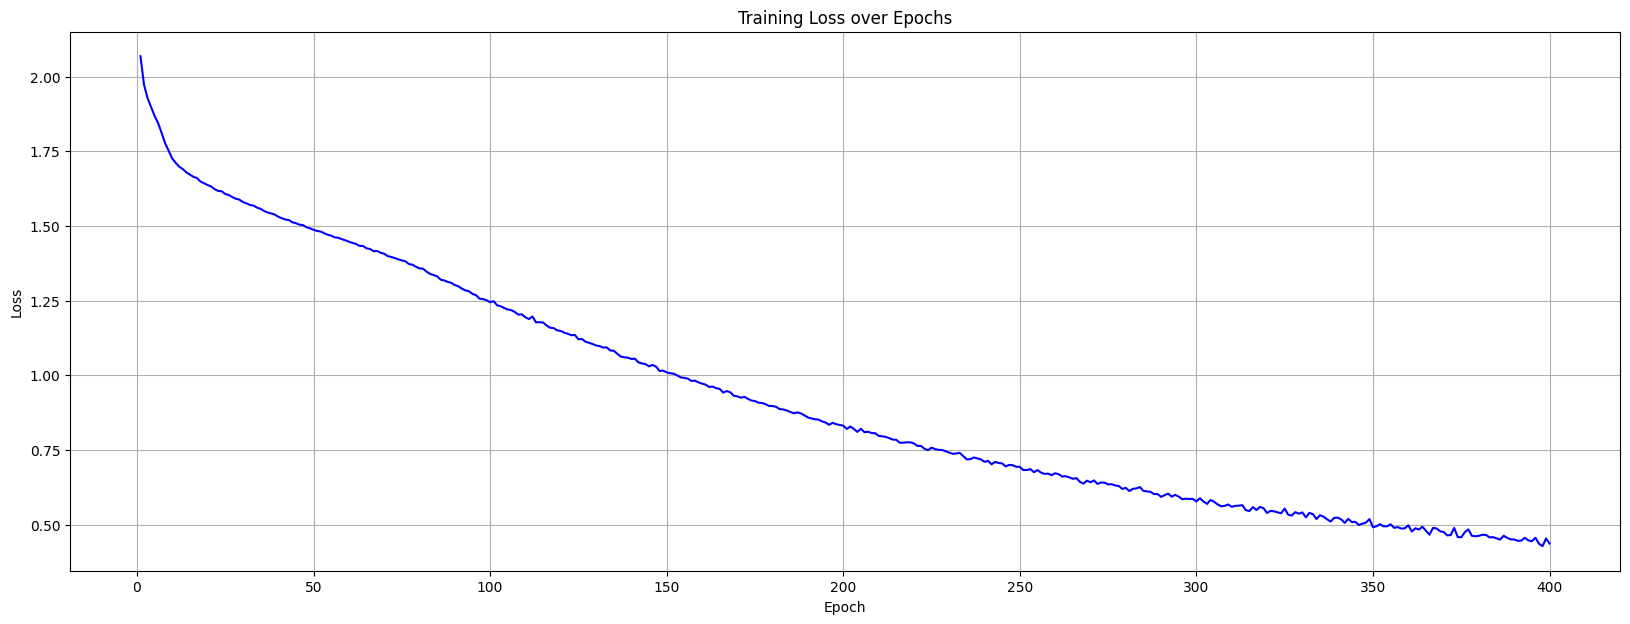

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(range(1, 400 + 1), train_losses, marker='', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [23]:
# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.float().to("cuda"), labels.to("cuda")
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.4216
